###Imports


In [3]:
!pip install tensorflow
!pip install matplotlib
!pip install gdown

In [4]:
import tensorflow as tf
from tensorflow.keras import models, layers
from matplotlib import pyplot as plt

import numpy as np

import gdown
import zipfile
import os

from sklearn.metrics import confusion_matrix
import seaborn as sns


###DataSet Downloading

In [5]:
# Download and extract dataset from Google Drive
url = "https://drive.google.com/uc?id=1x4XpoLDNkArvwmQnZ3VCmmE2ZAHhh7G-"
output = "PlantVillage.zip"

if not os.path.exists("PlantVillage"):
    gdown.download(url, output, quiet=False)
    with zipfile.ZipFile(output, 'r') as zip_ref:
        zip_ref.extractall(".")
    os.remove(output)


In [6]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_seed=42):
    ds_size = len(ds)
    if shuffle:
        ds = ds.shuffle(buffer_size=ds_size, seed=shuffle_seed)
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    test_size = int(test_split * ds_size)

    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)

    return train_ds, val_ds, test_ds


# POTATO



In [ ]:
IMAGE_SIZE = 256
BATCH_SIZE = 32
CHANNELS = 3

potato_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "PlantVillage/Potato",
    shuffle=True,
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    class_names=['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']
)



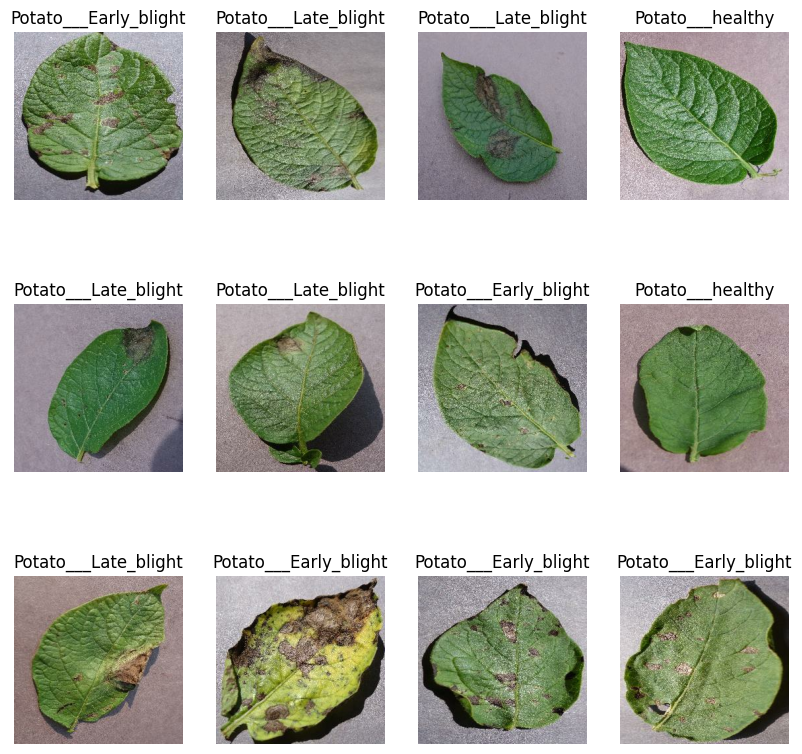

In [45]:
plt.figure(figsize=(10, 10))

for image_batch, label_batch in dataset.take(1):  # Take only first batch
    for i in range(min(12, len(image_batch))):  # Ensure we don't exceed batch size
        ax=plt.subplot(3, 4, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        # Get index of 1 in one-hot encoded label
        label_index = tf.argmax(label_batch[i]).numpy()
        plt.title(class_names[label_index])
        plt.axis("off")


In [ ]:
# # 80 % training
# # 20% : 10% validation 10% test

# train_size = 0.8
# train_ds = dataset.take(int(train_size * len(dataset)))
# test_ds = dataset.skip(int(train_size * len(dataset)))

# print(len(train_ds))
# val_ds = test_ds.take(int(0.5 * len(test_ds)))
# test_ds = test_ds.skip(int(0.5 * len(test_ds)))

# print(len(test_ds))
# print(len(val_ds))


In [47]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(potato_dataset)

class_names = potato_dataset.class_names
print(len(train_ds))
print(len(val_ds))
print(len(test_ds))



54
6
8


In [48]:
train_ds = train_ds.cache().shuffle(1000, seed=42).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000, seed=42).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000, seed=42).prefetch(buffer_size=tf.data.AUTOTUNE)



In [50]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
resize_and_rescale = tf.keras.Sequential([
    layers.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    layers.Rescaling(1.0/255)
])

data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.2),
])
model = models.Sequential([
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(32, (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, kernel_size=(3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, kernel_size=(3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(len(class_names), activation='softmax')
])
model.build(input_shape=input_shape)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [51]:
model.summary()


Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ sequential_6 (Sequential)            │ (32, 256, 256, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential_7 (Sequential)            │ (32, 256, 256, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_12 (Conv2D)                   │ (32, 254, 254, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_12 (MaxPooling2D)      │ (32, 127, 127, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_13 (Conv2D)                   │ (32, 125, 125, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_13 (MaxPooling2D)      │ (32, 62, 62, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_14 (Conv2D)                   │ (32, 60, 60, 64)            │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_14 (MaxPooling2D)      │ (32, 30, 30, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_15 (Conv2D)                   │ (32, 28, 28, 64)            │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_15 (MaxPooling2D)      │ (32, 14, 14, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_16 (Conv2D)                   │ (32, 12, 12, 64)            │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_16 (MaxPooling2D)      │ (32, 6, 6, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_17 (Conv2D)                   │ (32, 4, 4, 64)              │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_17 (MaxPooling2D)      │ (32, 2, 2, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (32, 256)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (32, 64)                    │          16,448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (32, 3)                     │             195 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 183,747 (717.76 KB)

 Trainable params: 183,747 (717.76 KB)

 Non-trainable params: 0 (0.00 B)

In [52]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),  # Changed from SparseCategoricalCrossentropy
    metrics=['accuracy']
)
EPOCHS = 50

In [53]:
history = model.fit(
    train_ds,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    verbose=1,
    validation_data=val_ds
)

Epoch 1/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 9s 88ms/step - accuracy: 0.4600 - loss: 0.9327 - val_accuracy: 0.5104 - val_loss: 0.8395
Epoch 2/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 8s 67ms/step - accuracy: 0.5615 - loss: 0.8342 - val_accuracy: 0.7604 - val_loss: 0.5785
Epoch 3/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 5s 63ms/step - accuracy: 0.7535 - loss: 0.6026 - val_accuracy: 0.7760 - val_loss: 0.5271
Epoch 4/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 5s 64ms/step - accuracy: 0.8675 - loss: 0.3660 - val_accuracy: 0.8542 - val_loss: 0.3428
Epoch 5/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 5s 63ms/step - accuracy: 0.8841 - loss: 0.3073 - val_accuracy: 0.8698 - val_loss: 0.3650
Epoch 6/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 5s 64ms/step - accuracy: 0.9044 - loss: 0.2330 - val_accuracy: 0.8490 - val_loss: 0.3743
Epoch 7/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 4s 66ms/step - accuracy: 0.9224 - loss: 0.2007 - val_accuracy: 0.9219 - val_loss: 0.1794
Epoch 8/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 5s 64ms/step - accuracy: 0.9213 - loss: 0.2007 - val_accuracy: 0.7292 - v

In [54]:
model.save('test_potato_disease_model.keras')
# saved_model = tf.keras.models.load_model('potato_disease_model.keras')



In [58]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(potato_dataset)

print(len(train_ds))
print(len(val_ds))
print(len(test_ds))



54
6
8


In [59]:
# # SAving Weights
model.save_weights('potato_disease.weights.h5')

# # loading weights
# model.load_weights('potato_disease.weights.h5')

scores = model.evaluate(test_ds)


8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.9903 - loss: 0.0270


In [60]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']


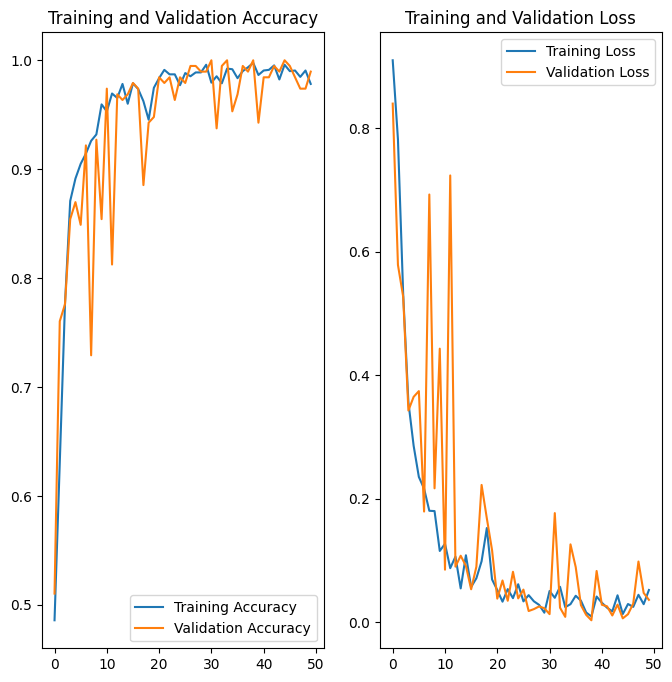

In [61]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

first image to predict
actual label: Potato___Early_blight
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step
predicted label: Potato___Early_blight


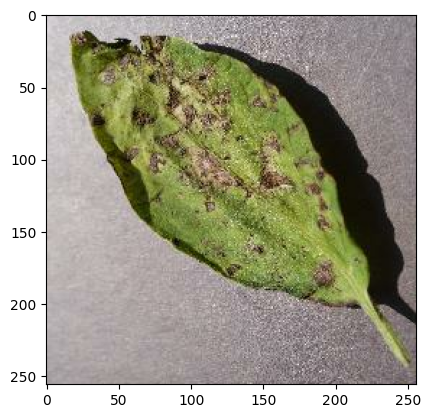

In [63]:
for images_batch, labels_batch in test_ds.take(1):

    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()

    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])

    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])


In [64]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


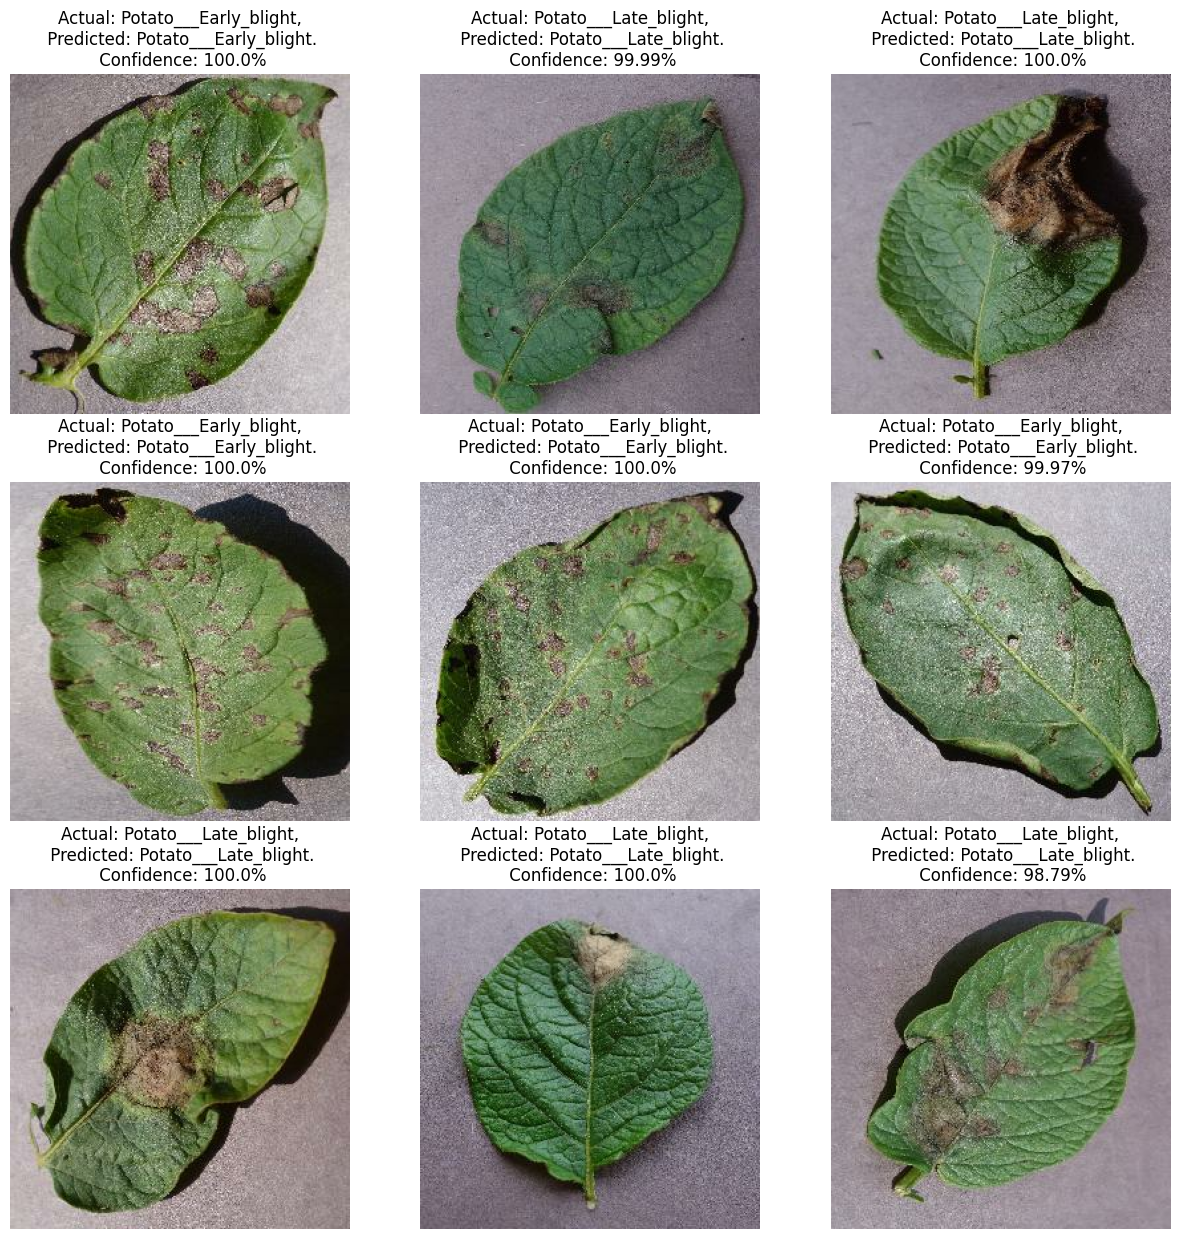

In [66]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))

        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]]

        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        plt.axis("off")

# TOMATO

In [7]:
IMAGE_SIZE = 128   # Drastically reduced from 256
BATCH_SIZE = 16    # Drastically reduced from 32
CHANNELS = 3

In [8]:
tomato_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "PlantVillage/Tomato",
    shuffle=True,
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    class_names=['Tomato__Target_Spot', 'Tomato__Tomato_mosaic_virus',
                 'Tomato__Tomato_YellowLeaf__Curl_Virus', 'Tomato_Bacterial_spot',
                 'Tomato_Early_blight', 'Tomato_healthy', 'Tomato_Late_blight',
                 'Tomato_Leaf_Mold', 'Tomato_Septoria_leaf_spot',
                 'Tomato_Spider_mites_Two_spotted_spider_mite']
)

Found 16011 files belonging to 10 classes.


In [9]:
# Set dataset to tomato
print(len(tomato_dataset))
class_names = tomato_dataset.class_names
print(class_names)



1001
['Tomato__Target_Spot', 'Tomato__Tomato_mosaic_virus', 'Tomato__Tomato_YellowLeaf__Curl_Virus', 'Tomato_Bacterial_spot', 'Tomato_Early_blight', 'Tomato_healthy', 'Tomato_Late_blight', 'Tomato_Leaf_Mold', 'Tomato_Septoria_leaf_spot', 'Tomato_Spider_mites_Two_spotted_spider_mite']


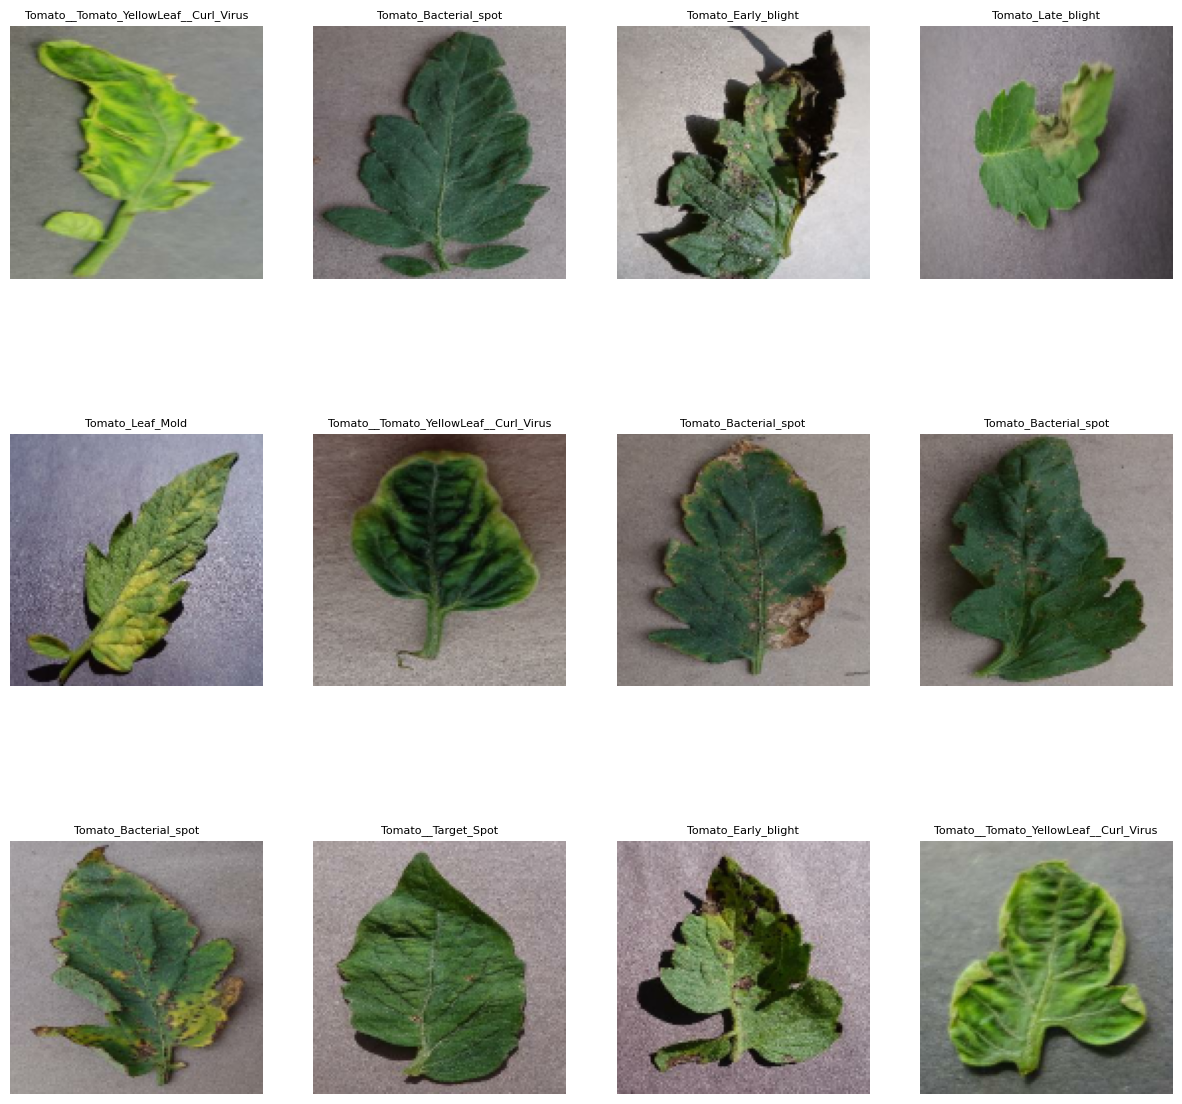

In [10]:
# Visualize the tomato images
plt.figure(figsize=(15, 15))  # Increased figure size due to more classes
for image_batch, label_batch in tomato_dataset.take(1):
    for i in range(min(12, len(image_batch))):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        label_index = label_batch[i]
        plt.title(class_names[label_index], fontsize=8)
        plt.axis("off")



In [11]:
# Split the dataset
train_ds, val_ds, test_ds = get_dataset_partitions_tf(tomato_dataset)
print(f"Training size: {len(train_ds)}")
print(f"Validation size: {len(val_ds)}")
print(f"Test size: {len(test_ds)}")



Training size: 800
Validation size: 100
Test size: 101


In [12]:
# Optimize the data pipeline
train_ds = train_ds.cache().shuffle(1000, seed=42).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000, seed=42).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000, seed=42).prefetch(buffer_size=tf.data.AUTOTUNE)



In [13]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)

resize_and_rescale = tf.keras.Sequential([
    layers.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    layers.Rescaling(1.0/255)
])

data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.2),
])

model = models.Sequential([
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(32, (3,3), activation='relu', padding='same'),  # Added padding='same'
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.25),
    layers.Conv2D(64, kernel_size=(3,3), activation='relu', padding='same'),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.25),
    layers.Conv2D(64, kernel_size=(3,3), activation='relu', padding='same'),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.25),
    layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.25),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(len(class_names), activation='softmax')
])
model.build(input_shape=input_shape)



In [14]:
# Compile and train
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)



In [15]:
EPOCHS = 75
history = model.fit(
    train_ds,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    verbose=1,
    validation_data=val_ds
)

Epoch 1/75
800/800 ━━━━━━━━━━━━━━━━━━━━ 55s 31ms/step - accuracy: 0.2778 - loss: 2.0211 - val_accuracy: 0.4489 - val_loss: 1.4907
Epoch 2/75
800/800 ━━━━━━━━━━━━━━━━━━━━ 14s 17ms/step - accuracy: 0.5209 - loss: 1.3793 - val_accuracy: 0.5944 - val_loss: 1.1243
Epoch 3/75
800/800 ━━━━━━━━━━━━━━━━━━━━ 13s 17ms/step - accuracy: 0.6389 - loss: 1.0371 - val_accuracy: 0.6903 - val_loss: 0.8910
Epoch 4/75
800/800 ━━━━━━━━━━━━━━━━━━━━ 20s 16ms/step - accuracy: 0.7031 - loss: 0.8430 - val_accuracy: 0.7248 - val_loss: 0.8349
Epoch 5/75
800/800 ━━━━━━━━━━━━━━━━━━━━ 20s 16ms/step - accuracy: 0.7419 - loss: 0.7462 - val_accuracy: 0.7448 - val_loss: 0.6914
Epoch 6/75
800/800 ━━━━━━━━━━━━━━━━━━━━ 21s 16ms/step - accuracy: 0.7730 - loss: 0.6368 - val_accuracy: 0.8426 - val_loss: 0.4837
Epoch 7/75
800/800 ━━━━━━━━━━━━━━━━━━━━ 20s 16ms/step - accuracy: 0.8087 - loss: 0.5707 - val_accuracy: 0.8288 - val_loss: 0.5066
Epoch 8/75
800/800 ━━━━━━━━━━━━━━━━━━━━ 13s 16ms/step - accuracy: 0.8116 - loss: 0.5396 - 

In [31]:
# Save the model (uncomment when ready to save)
model.save('t1omato_disease_model.keras')
model.save_weights('1tomato_disease.weights.h5')
# from google.colab import drive
# drive.mount('/content/drive')

model_save_path = '/content/drive/My Drive/t1omato_disease_model.keras'
weights_save_path = '/content/drive/My Drive/1tomato_disease.weights.h5'

model.save(model_save_path)
model.save_weights(weights_save_path)


In [17]:
# Plot training results
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']


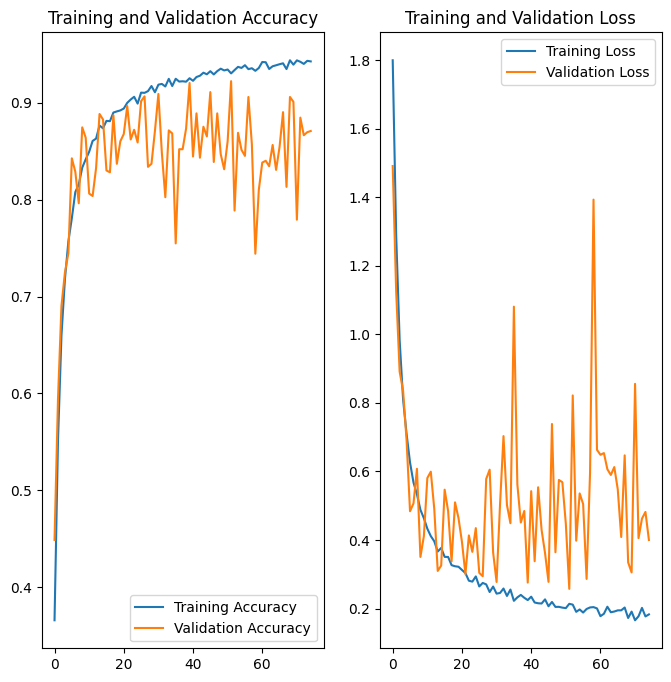

In [18]:
epochs_range = range(EPOCHS)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()


In [26]:
# Evaluate on test dataset
test_loss, test_acc = model.evaluate(test_ds)
print('\nTest accuracy:', test_acc)


101/101 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8800 - loss: 0.3435

Test accuracy: 0.875


101/101 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


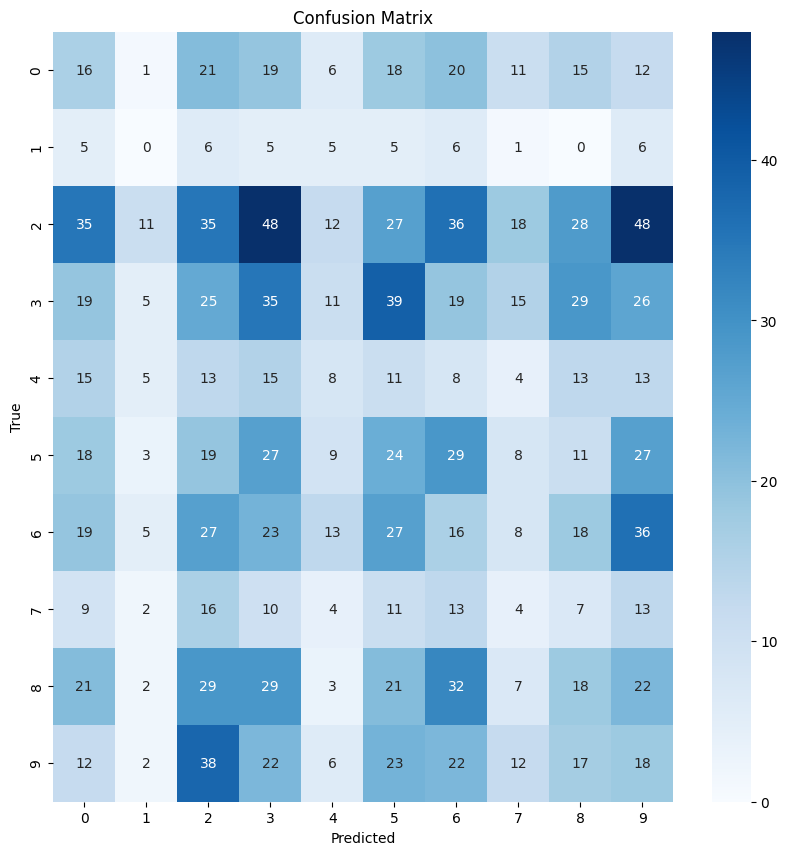

In [32]:
# Make predictions on test dataset
predictions = model.predict(test_ds)
predicted_classes = np.argmax(predictions, axis=1)

# Get actual labels
test_labels = np.concatenate([y for x, y in test_ds], axis=0)

# Plot confusion matrix

cm = confusion_matrix(test_labels, predicted_classes)
plt.figure(figsize=(10,10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()



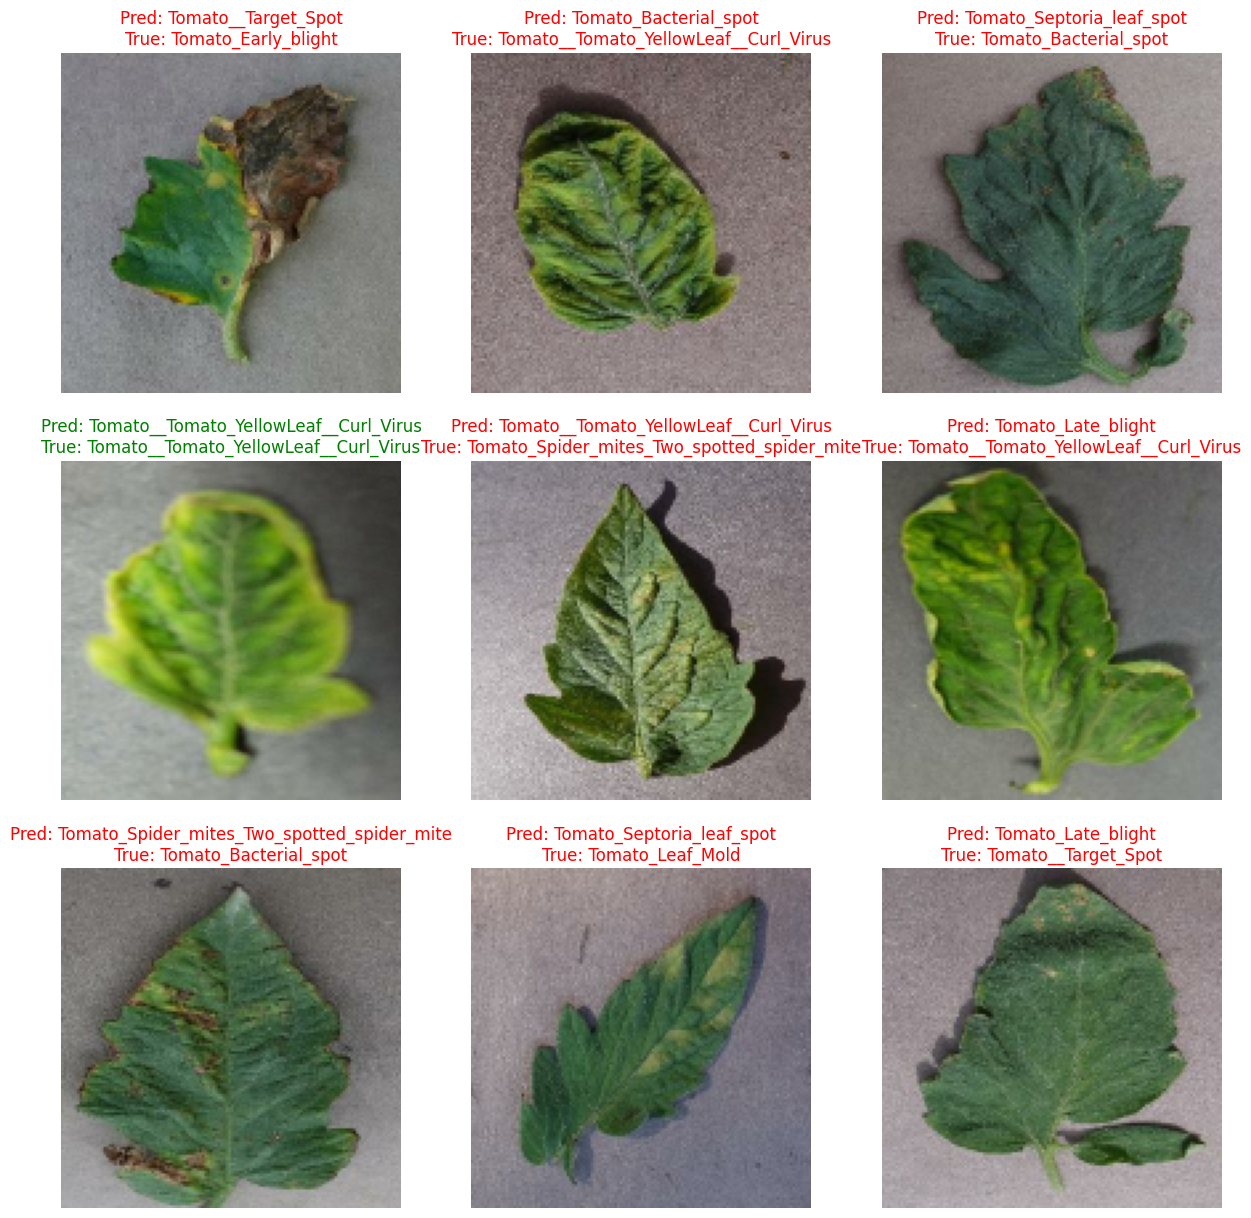

In [33]:
# Plot some example predictions
plt.figure(figsize=(15,15))
for images, labels in test_ds.take(1):
    num_images = min(9, images.shape[0])
    for i in range(num_images):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))

        predicted_class = class_names[predicted_classes[i]]
        true_class = class_names[labels[i]]

        title_color = 'green' if predicted_class == true_class else 'red'
        plt.title(f'Pred: {predicted_class}\nTrue: {true_class}', color=title_color)
        plt.axis("off")
plt.show()
